In [1]:
# Libraries
import os
import numpy as np
!conda install --yes pandas 
!conda install -c conda-forge --yes ipywidgets
import pandas as pd

import cv2
!conda install --yes seaborn 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import gc
import time
import copy
from tqdm import tqdm
from sklearn.utils import compute_class_weight
from PIL import Image
import math
from glob import glob

In [2]:
# Hyper parameters
NUM_CLASSES = 2 # Labels: 0 - Non IDC, 1 - IDC
BATCH_SIZE = 32

# CNN
NUM_EPOCHS_CNN = 1
BATCH_SIZE_CNN  = 128
learning_rate_CNN = 0.002

# Resnet
NUM_EPOCHS_RESNET = 1
BATCH_SIZE_RESNET  = 128
BATCH_SIZE_RESNET2  = 128
learning_rate_RESNET  = 0.0005
learning_rate_RESNET2 = 0.002
run_training = True
retrain = False
find_learning_rate = True

# DensNet
learning_rate_DensNet  = 0.002
NUM_EPOCHS_DENSNET = 1
BATCH_SIZE_DensNet = 64

In [3]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Quadro M4000'

Read the data (images) and create a csv file, dataset object and data loaders

In [4]:
x=[] # x coordinate of an image
SelectedImageData = [] # For the csv and the dataloaders
y=[] # y coordinate of an image
ID=[] # ID of a patient
cl=[] # class (0 for non IDC, 1 for IDC)
target=[] # class
matrix = [] # All the image data
i = 0
imagePatches = glob('../IDC_regular_ps50_idx5/**/*.png', recursive=True)
print("ImagePatches length (Total number of images): ", len(imagePatches))
print("imagePatches[0] (Checking if we read the file name): ", imagePatches[0])

# Go over all the images and create a dataset csv file including: x coordinate, y coordinate, target(label: 0-non IDC, 1-IDC), ID - Patient ID
for img in imagePatches:
    # For each image path extract the data from the image name
    imagePatches1=imagePatches[i].split("/")
    imagePatches2=imagePatches1[-1].split("_")
    x=imagePatches2[2].split("x")
    x=x[1]
    y=imagePatches2[3].split("y")
    y=y[1]
    target=imagePatches2[4].split(".png")
    cl=target[0]
   
    if cl=='class0':
        cl=0
    elif cl=='class1':
         cl=1
    ID=imagePatches2[0]
    filename=imagePatches[i]
    SelectedImageData = [ID,x,y,filename,cl]
    column_names = ["patient_id","x","y","filename","target"]
    matrix.append(SelectedImageData)
    i=i+1

ImagePatches length (Total number of images):  277524
imagePatches[0] (Checking if we read the file name):  ../IDC_regular_ps50_idx5/12910/1/12910_idx5_x651_y201_class1.png


In [5]:
base_path = "../IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)

# Add fully defined column into the row
images_df = pd.DataFrame(matrix, columns = column_names)

In [6]:
print("Create csv file")
# Create the dataset csv
images_df.to_csv(r'dataset.csv', index = False) 

Create csv file


In [7]:
files = os.listdir("../IDC_regular_ps50_idx5/")
print("Number of folders (Patients): ", len(files))

Number of folders (Patients):  279


In [8]:
# read csv file and return the created dataset (cancer_perc - precent of cancer images per patinet)
dataset = pd.read_csv("dataset.csv", usecols=['patient_id', 'filename','target'])
cancer_perc = dataset.groupby("patient_id").target.value_counts()/ dataset.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()
print("cancer_perc:" ,cancer_perc)

cancer_perc: target             0         1
patient_id                    
8863        0.788560  0.211440
8864        0.710503  0.289497
8865        0.922753  0.077247
8867        0.901340  0.098660
8913        0.914136  0.085864
...              ...       ...
16568       0.658213  0.341787
16569       0.896142  0.103858
16570       0.408942  0.591058
16895       0.761589  0.238411
16896       0.902396  0.097604

[279 rows x 2 columns]


Data Analyze

In [46]:
def Exploratory_analysis(dataset):
    print("Exploratory_analysis:")
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    sns.histplot(dataset.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
    ax[0].set_xlabel("Number of patches")
    ax[0].set_ylabel("Number of patients");
    ax[0].set_title("How many patches do we have per patient?");
    sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
    ax[1].set_title("How much percentage of an image is covered by IDC?")
    ax[1].set_ylabel("Number of patients")
    ax[1].set_xlabel("% of patches with IDC");
    sns.countplot(dataset.target, palette="Set2", ax=ax[2]);
    ax[2].set_xlabel("no(0) versus yes(1)")
    ax[2].set_title("How many patches show IDC?");
    plt.show()
    return

Exploratory_analysis:


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


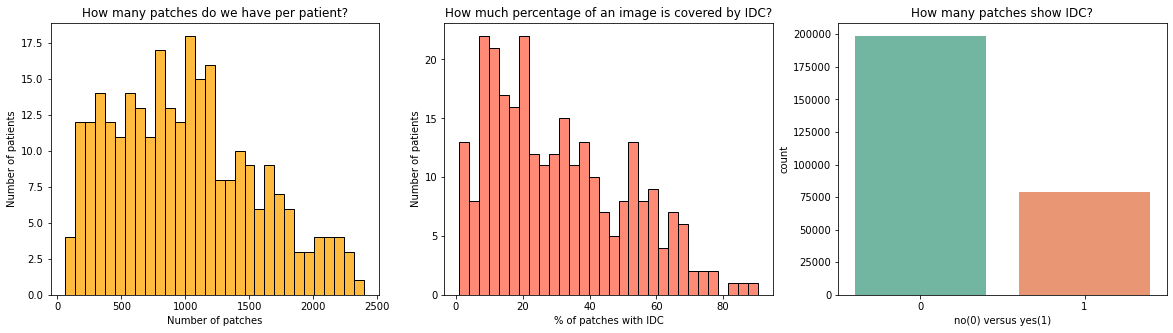

In [47]:
# Create graphs that represents: how many patches per patient, how much precentage of an image is covered by IDC, how many pathes show IDC
Exploratory_analysis(dataset)

In [49]:
def Positive_or_Negative(dataset):
    dataset.target = dataset.target.astype(int)
    pos_selection = np.random.choice(dataset[dataset.target==1].index.values, size=50, replace=False)
    neg_selection = np.random.choice(dataset[dataset.target==0].index.values, size=50, replace=False) 
    return pos_selection,neg_selection

In [50]:
#Looking at healthy and cancer patches
pos_selection,neg_selection=Positive_or_Negative(dataset)

In [52]:
#Cancer patches
def cancer_patches(pos_selection):
    print("Cancer patches:")
    fig, ax = plt.subplots(5,10,figsize=(20,10))    
    for n in range(5):
        for m in range(10):
            idx = pos_selection[m + 10*n]
            image = cv2.imread(dataset.loc[idx, "filename"])
            ax[n,m].imshow(image)
            ax[n,m].grid(False)
    plt.show()       
    return

In [54]:
#Healthy patches
def Healthy_patches(neg_selection): 
    print("Healthy patches:")
    fig, ax = plt.subplots(5,10,figsize=(20,10))
    for n in range(5):
        for m in range(10):
            idx = neg_selection[m + 10*n]
            image = cv2.imread(dataset.loc[idx, "filename"])
            ax[n,m].imshow(image)
            ax[n,m].grid(False)
    plt.show()
    return

Examples of 50 cancer and 50 healthy pathces:
Cancer patches:


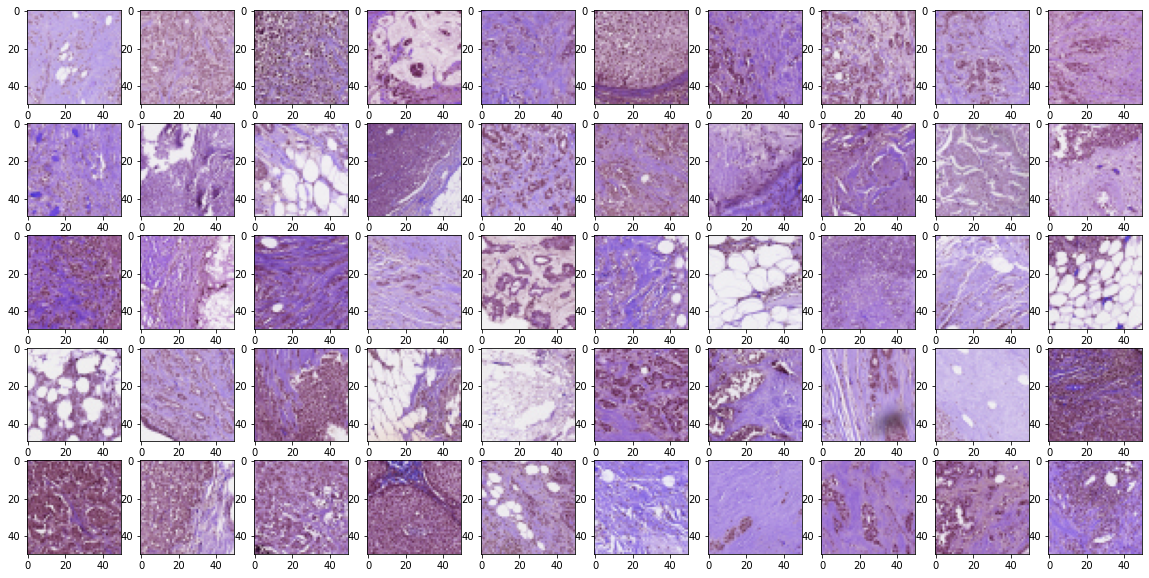

Healthy patches:


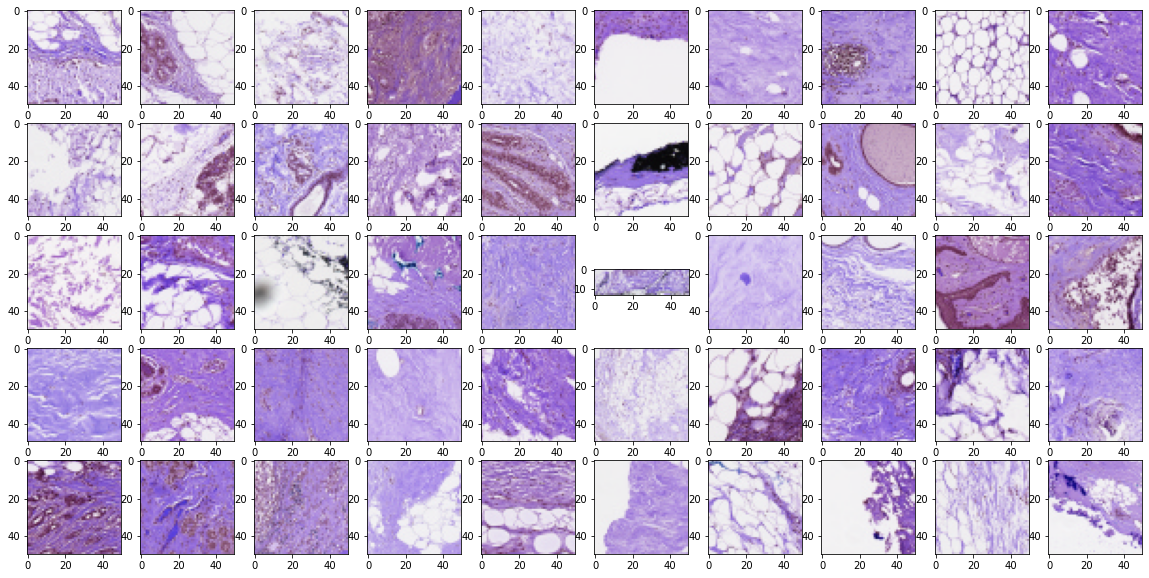

In [55]:
print("Examples of 50 cancer and 50 healthy pathces:")
cancer_patches(pos_selection)
Healthy_patches(neg_selection)

In [60]:
def tissue_slice(dataset):
    print("Tissue slice in patient:")
    fig, ax = plt.subplots(5,3,figsize=(20, 27))

    patient_ids = dataset.patient_id.unique()

    for n in range(5):
        for m in range(3):
            patient_id = patient_ids[m + 3*n]
            example_df = get_patient_dataframe(patient_id)
            ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
            ax[n,m].set_title("patient " + str(patient_id))
            ax[n,m].set_xlabel("x coord")
            ax[n,m].set_ylabel("y coord")
    plt.show()
    return patient_id

def get_cancer_dataframe(patient_id,cancer_id):
    #print("patient_id: " , patient_id)
    #print("cancer_id: " , cancer_id)
    path = base_path+str(int(patient_id))+"/"+ str(int(cancer_id))
    #print("path: " path)
    files = os.listdir(path)    
    dataframe = pd.DataFrame(files, columns=['filename'])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1])
    return patient_df

Tissue slice in patient:


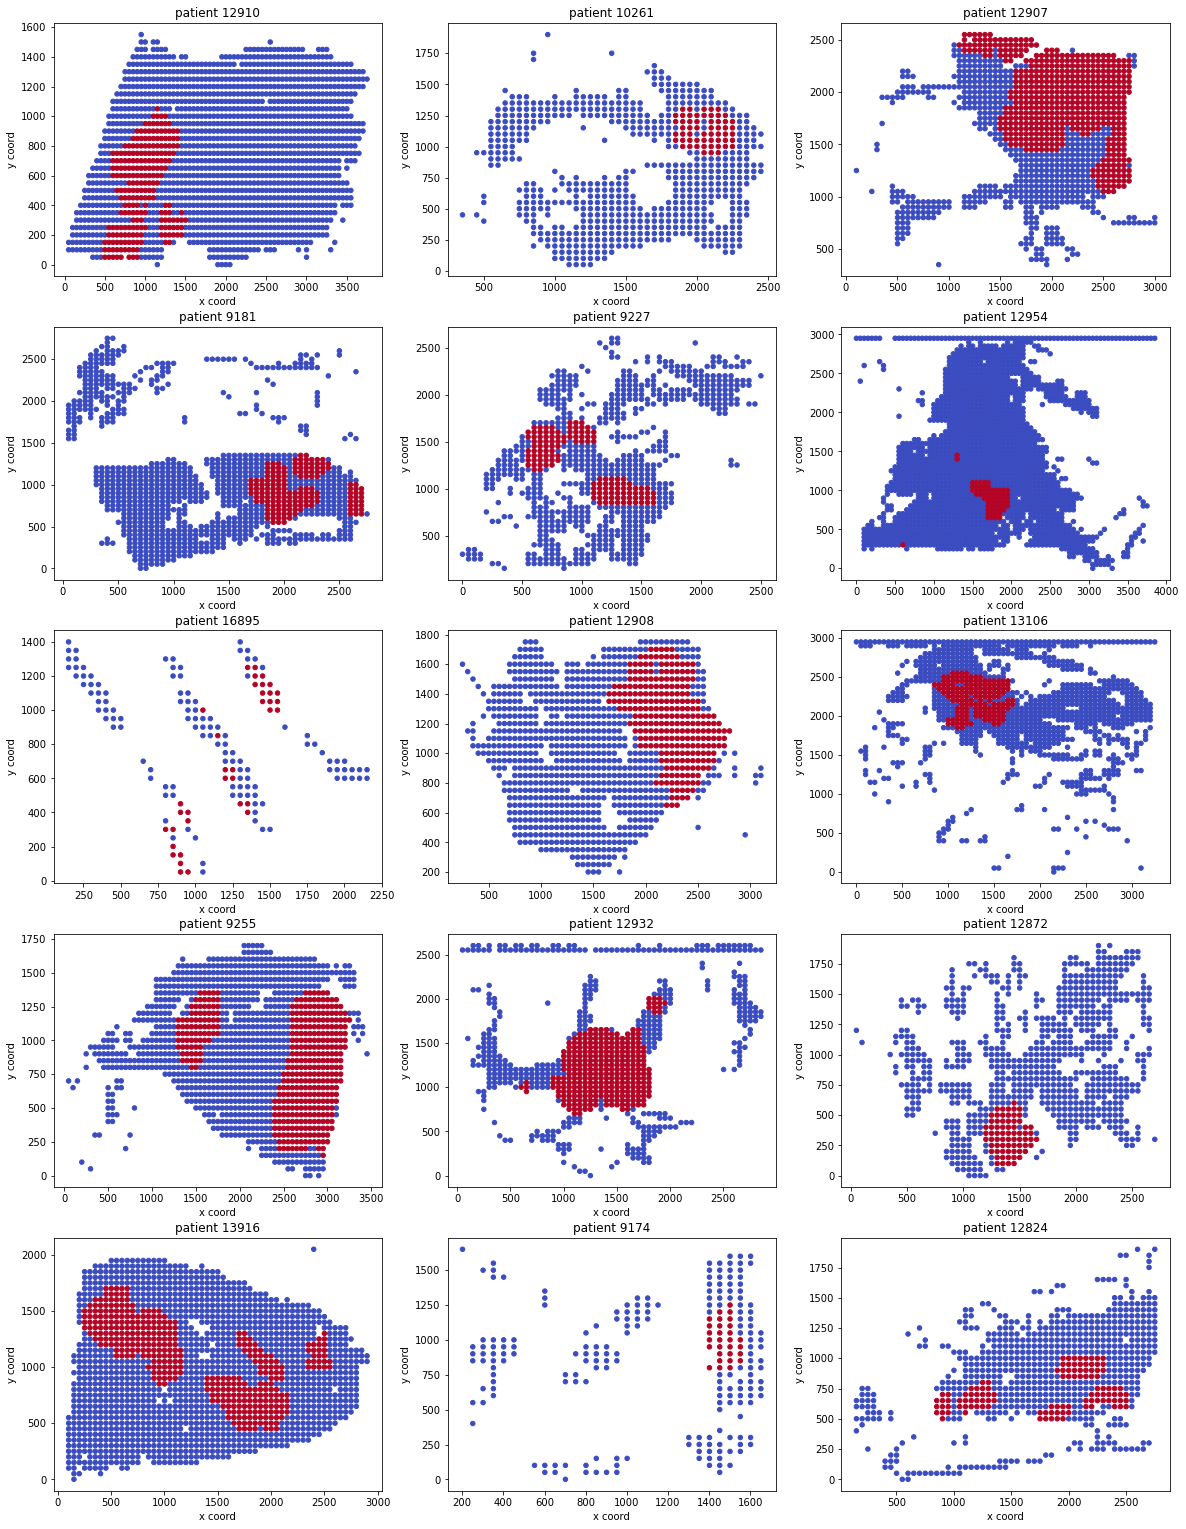

12824

In [61]:
# Visualisation per tissue slice. Red dots means IDC, blue means non IDC. Empty cells means missing patches.
tissue_slice(dataset)

In [63]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = cv2.imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [65]:
def example_fig(grid,mask,patient_id):
    print("Example_Fig:")
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("x-coord")
        ax[m].set_ylabel("y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + str(patient_id))
    ax[1].set_title("Cancer tissue colored red \n of patient: " + str(patient_id));
    plt.show()
    broken_patches
    return

Example_Fig:


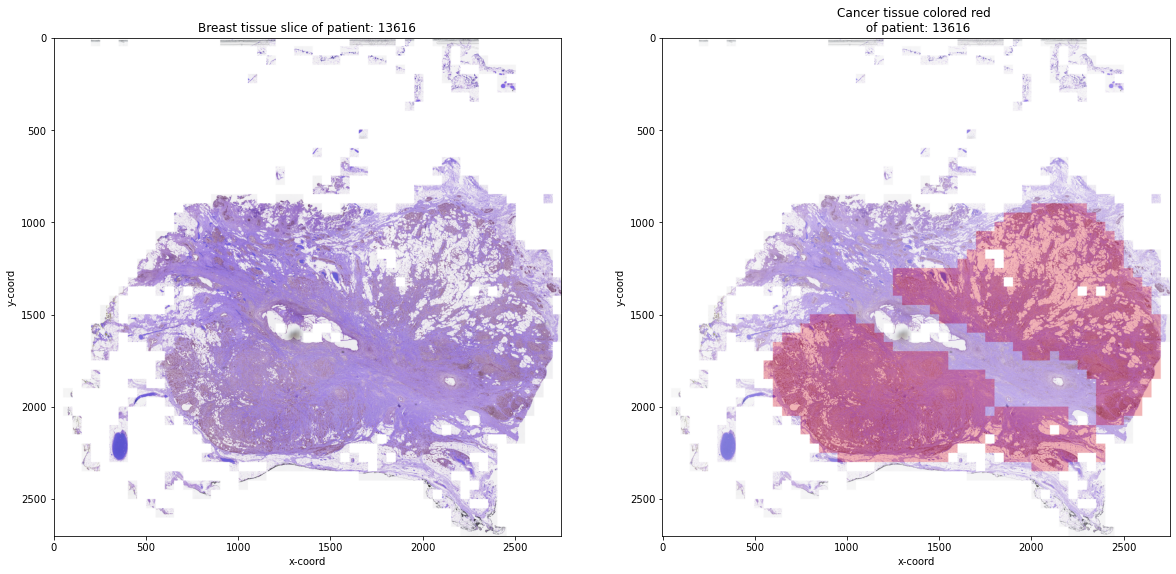

In [66]:
# Let's use an example patient with id 13616:
# Red colored cells means IDC
patient_id = "13616"
grid, mask, broken_patches, mask_proba = visualise_breast_tissue(patient_id, pred_df=None)
example_fig(grid,mask,patient_id)

In [9]:
# Splitting data into train and test: 0.2 for test 0.8 for train
train, test = train_test_split(images_df, stratify=images_df.target, test_size=0.2,train_size=0.8)
print("Train length: %d Test length %d" %(len(train), len(test)))
print("\nTrain head: ", train.head())
print("\nTest head: ", test.head())

Train length: 222019 Test length 55505

Train head:         patient_id     x     y  \
70326        8917   901   851   
269804      14304  1551   351   
253279      12909   651   901   
74039        9322  2201   151   
232477      10308  1901  2501   

                                                 filename  target  
70326   ../IDC_regular_ps50_idx5/8917/1/8917_idx5_x901...       1  
269804  ../IDC_regular_ps50_idx5/14304/1/14304_idx5_x1...       1  
253279  ../IDC_regular_ps50_idx5/12909/1/12909_idx5_x6...       1  
74039   ../IDC_regular_ps50_idx5/9322/0/9322_idx5_x220...       0  
232477  ../IDC_regular_ps50_idx5/10308/0/10308_idx5_x1...       0  

Test head:         patient_id     x     y  \
100515       9123  1651  1951   
218336       9290  2801   751   
54593       12870  2851  2251   
239576      13613  1901   251   
224888      12750  2351   751   

                                                 filename  target  
100515  ../IDC_regular_ps50_idx5/9123/0/9123_idx5_x165...   

In [10]:
train = train[["filename","target"]]
test = test[["filename","target"]]
print("Train head: ", train.head())
print("\nTest head: ", test.head())

Train head:                                                   filename  target
70326   ../IDC_regular_ps50_idx5/8917/1/8917_idx5_x901...       1
269804  ../IDC_regular_ps50_idx5/14304/1/14304_idx5_x1...       1
253279  ../IDC_regular_ps50_idx5/12909/1/12909_idx5_x6...       1
74039   ../IDC_regular_ps50_idx5/9322/0/9322_idx5_x220...       0
232477  ../IDC_regular_ps50_idx5/10308/0/10308_idx5_x1...       0

Test head:                                                   filename  target
100515  ../IDC_regular_ps50_idx5/9123/0/9123_idx5_x165...       0
218336  ../IDC_regular_ps50_idx5/9290/0/9290_idx5_x280...       0
54593   ../IDC_regular_ps50_idx5/12870/0/12870_idx5_x2...       0
239576  ../IDC_regular_ps50_idx5/13613/0/13613_idx5_x1...       0
224888  ../IDC_regular_ps50_idx5/12750/0/12750_idx5_x2...       0


In [11]:
class MyDataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path,label = self.df[index]
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [88]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [13]:
dataset_train = MyDataset(df_data = train, transform=trans_train)
dataset_test = MyDataset(df_data = test,transform=trans_test)

In [14]:
loader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True, drop_last=True, num_workers=0)
loader_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE//2, shuffle=False, num_workers=0)

loader_train_cnn = DataLoader(dataset_train, batch_size = BATCH_SIZE_CNN, shuffle = True, drop_last=True, num_workers=0)
loader_train_resnet = DataLoader(dataset_train, batch_size = BATCH_SIZE_RESNET, shuffle = True, drop_last=True, num_workers=0)
loader_train_resnet2 = DataLoader(dataset_train, batch_size = BATCH_SIZE_RESNET2, shuffle = True, drop_last=True, num_workers=0)
loader_train_resnet_densnet = DataLoader(dataset_train, batch_size = BATCH_SIZE_DensNet, shuffle = True, drop_last=True, num_workers=0)

print("Interaction for train and test:")
print(len(loader_train), len(loader_test))

Interaction for train and test:
6938 3470


In [15]:
# Train the model
def train_model(NUM_EPOCHS, loader_train, optimizer, criterion, model, ModelCheckPointName, loss_acc = 100):
    print("Train started:")
    model.to(device)
    loss_array=[]
    x=[]
    total_step = len(loader_train)
    test_loss , test_accuracy = [], []
    start = time.time()
    curr_time = 0
    running_loss = 0
    for epoch in range(NUM_EPOCHS):
        torch.cuda.synchronize()
    
        tk0 = tqdm(loader_train, total=int(len(loader_train)),desc= "Progress: ")
        
        for i, (filename, target) in enumerate(tk0):
            
            filename = filename.to(device)
            target = target.to(device)
        
            # Forward pass
            outputs = model(filename)
            loss = criterion(outputs, target)
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Finished loss_acc iterations
            if(i+1) % loss_acc == 0:
                torch.cuda.synchronize()
                loss_array.append(running_loss / loss_acc) 
                running_loss = 0
        
            # Finished an epoch
            elif (i+1) % len(loader_train) == 0:
                torch.cuda.synchronize()                                
                # Save the model checkpoint
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_array': loss_array,
                }, 'models/Model_' + ModelCheckPointName + '.pth')
                  
    stop = time.time()
    time_diff = stop-start
    total_time = time_diff/60
    return loss_array, total_time

In [16]:
# Test the model
def Test_model(model):
    print("Test started:")
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        tk0 = tqdm(loader_test, total=int(len(loader_test)),desc= "Progress: ")
        for filename, target in tk0:
            filename = filename.to(device)
            target = target.to(device)
            outputs = model(filename)               
            temp, predicted = torch.max(outputs.data, 1)               
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    #print(confusion_matrix)    
    return Test_acc, confusion_matrix   

In [17]:
# Test the model
def plots(loss_array, ModelName):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(loss_array, color = 'orange', label = 'Train Loss - '+ ModelName)
    plt.xlabel('Iteretions')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('models/Model_' + ModelName + '_Loss.png')
    plt.show()

CNN Model

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)            
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * 1 * 1, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))   
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [19]:
# Create the model
model_Cnn = SimpleCNN()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adamax(model_Cnn.parameters(), lr = learning_rate_CNN)

In [20]:
# Train the model
loss_array_cnn, total_time = train_model(NUM_EPOCHS_CNN,loader_train_cnn, optimizer_cnn,criterion_cnn,model_Cnn,"Model_Cnn",loss_acc = 50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 1734/1734 [40:49<00:00,  1.41s/it]

Total time for training:  40.829888105392456


Test started:


Progress: 100%|██████████| 3470/3470 [09:26<00:00,  6.12it/s]


confusion_matrix:  tensor([[36864.,  2884.],
        [ 4260., 11497.]])
All_Epochs [1],Test_accuracy:87.12908746959734


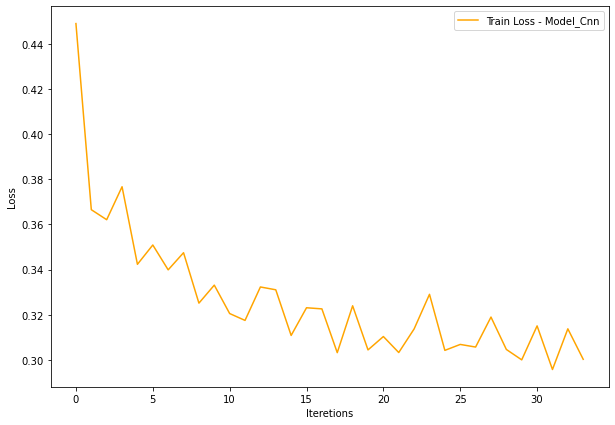

In [21]:
Test_acc, confusion_matrix = Test_model(model_Cnn)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_CNN,Test_acc))
plots(loss_array_cnn, "Model_Cnn") # loss plots

End of CNN Model

CNN2 Model

In [22]:
loader_train_cnn = DataLoader(dataset_train, batch_size = 64, shuffle = True, drop_last=True, num_workers=0)

In [23]:
# Create the model
model_Cnn2 = SimpleCNN()
criterion_cnn2 = nn.CrossEntropyLoss()
optimizer_cnn2 = torch.optim.Adamax(model_Cnn2.parameters(), lr = 0.002)

In [24]:
# Train the model
loss_array_cnn, total_time = train_model(NUM_EPOCHS_CNN,loader_train_cnn, optimizer_cnn2,criterion_cnn2,model_Cnn2,"Model_Cnn",loss_acc = 50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 3469/3469 [41:06<00:00,  1.41it/s]

Total time for training:  41.10954942305883


Test started:


Progress: 100%|██████████| 3470/3470 [10:06<00:00,  5.72it/s]


confusion_matrix:  tensor([[35843.,  3905.],
        [ 2878., 12879.]])
All_Epochs [1],Test_accuracy:87.77947932618683


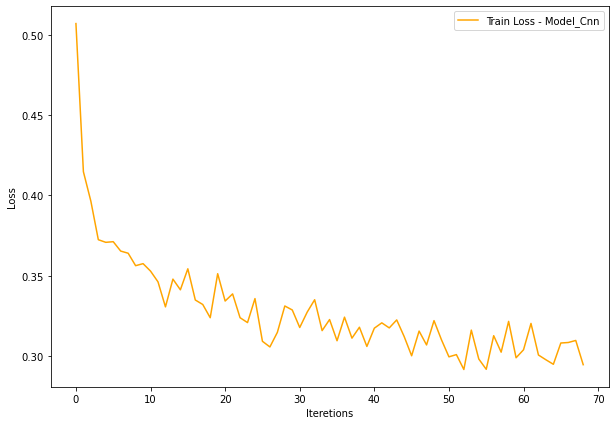

In [25]:
Test_acc, confusion_matrix = Test_model(model_Cnn2)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_CNN,Test_acc))
plots(loss_array_cnn, "Model_Cnn") # loss plots

CNN3 Model

In [26]:
loader_train_cnn = DataLoader(dataset_train, batch_size = 128, shuffle = True, drop_last=True, num_workers=0)

In [27]:
# Create the model
model_Cnn3 = SimpleCNN()
criterion_cnn3 = nn.CrossEntropyLoss()
optimizer_cnn3 = torch.optim.Adamax(model_Cnn3.parameters(), lr = 0.02)

In [28]:
# Train the model
loss_array_cnn, total_time = train_model(NUM_EPOCHS_CNN,loader_train_cnn, optimizer_cnn3,criterion_cnn3,model_Cnn3,"Model_Cnn",loss_acc = 50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 1734/1734 [41:55<00:00,  1.45s/it]

Total time for training:  41.921430893739064


Test started:


Progress: 100%|██████████| 3470/3470 [09:44<00:00,  5.94it/s]


confusion_matrix:  tensor([[37464.,  2284.],
        [ 5010., 10747.]])
All_Epochs [1],Test_accuracy:86.85884154580668


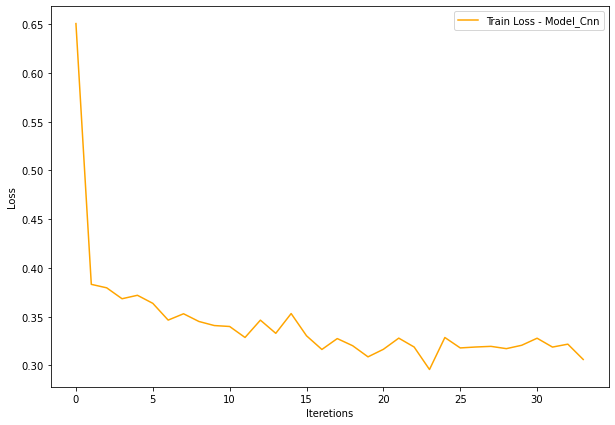

In [29]:
Test_acc, confusion_matrix = Test_model(model_Cnn3)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_CNN,Test_acc))
plots(loss_array_cnn, "Model_Cnn") # loss plots

In [ ]:
loader_train_cnn = DataLoader(dataset_train, batch_size = 128, shuffle = True, drop_last=True, num_workers=0)

In [ ]:
# Create the model
model_Cnn4 = SimpleCNN()
criterion_cnn4 = nn.CrossEntropyLoss()
optimizer_cnn4 = torch.optim.Adamax(model_Cnn4.parameters(), lr = 0.05)

In [ ]:
# Train the model
loss_array_cnn, total_time = train_model(NUM_EPOCHS_CNN,loader_train_cnn, optimizer_cnn4,criterion_cnn4,model_Cnn4,"Model_Cnn",loss_acc = 50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 1734/1734 [41:42<00:00,  1.44s/it]

Total time for training:  41.7088366150856


Test started:


Progress: 100%|██████████| 3470/3470 [09:55<00:00,  5.83it/s]


confusion_matrix:  tensor([[31063.,  8685.],
        [ 1981., 13776.]])
All_Epochs [1],Test_accuracy:80.78371317899288


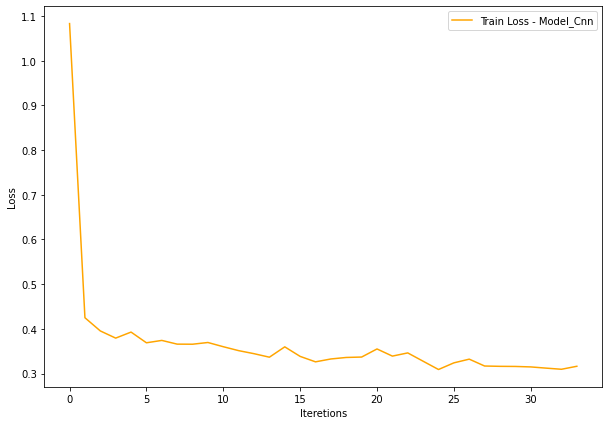

In [ ]:
Test_acc, confusion_matrix = Test_model(model_Cnn4)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_CNN,Test_acc))
plots(loss_array_cnn, "Model_Cnn") # loss plots

Start of Resnet18 Model

In [26]:
def weights(device,train_df):    
    weights = compute_class_weight(y=train_df.target.values, class_weight = "balanced", classes = train_df.target.unique())    
    class_weights = torch.FloatTensor(weights)
    if device.type == "cuda":
        class_weights = class_weights.cuda()
    print(class_weights)
    train_df.target.unique()
    return class_weights

In [27]:
model_resnet = torchvision.models.resnet18(pretrained=False)
num_features = model_resnet.fc.in_features
print(num_features)

model_resnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model_resnet.apply(init_weights)
model_resnet = model_resnet.to(device)

512


In [28]:
class_weights = weights(device,train)
print("class_weights:\n", class_weights)
criterion_resnet = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet = torch.optim.Adamax(model_resnet.fc.parameters(), lr = learning_rate_RESNET) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

tensor([1.7612, 0.6982], device='cuda:0')
class_weights:
 tensor([1.7612, 0.6982], device='cuda:0')


In [29]:
loss_array_RESNET, total_time = train_model(NUM_EPOCHS_RESNET,loader_train,optimizer_resnet,criterion_resnet,model_resnet, "Model_Resnet",loss_acc = 50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 6938/6938 [52:29<00:00,  2.20it/s]  

Total time for training:  52.49556108315786


Test started:


Progress: 100%|██████████| 3470/3470 [09:20<00:00,  6.19it/s]


81.68633456445366
tensor([[37969.,  1779.],
        [ 8386.,  7371.]])


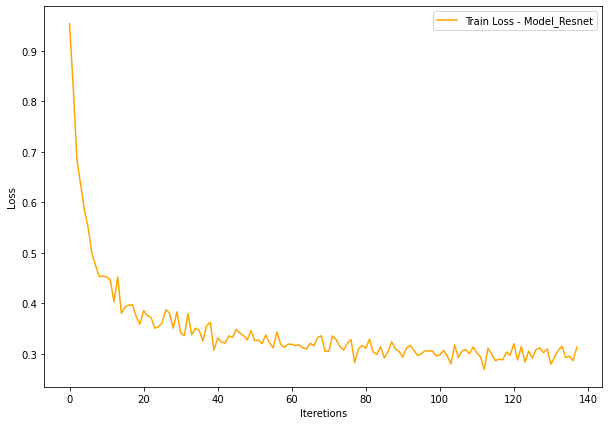

In [30]:
Test_acc, confusion_matrix = Test_model(model_resnet)
print(Test_acc)
print(confusion_matrix)
plots(loss_array_RESNET, "Model_Resnet") # loss plots

Resnet18 Module2

In [ ]:
model2_resnet18 = torchvision.models.resnet18(pretrained=False)
num_features = model2_resnet18.fc.in_features
print(num_features)

model2_resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model2_resnet18.apply(init_weights)
model2_resnet18 = model2_resnet18.to(device)

512


In [ ]:
class_weights = weights(device,train)
print("class_weights:\n", class_weights)
criterion_resnet18_2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet18_2 = torch.optim.Adamax(model2_resnet18.fc.parameters(), lr = 0.005) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

tensor([0.6982, 1.7612], device='cuda:0')
class_weights:
 tensor([0.6982, 1.7612], device='cuda:0')


In [ ]:
loss_array_RESNET, total_time = train_model(NUM_EPOCHS_RESNET,loader_train,optimizer_resnet18_2,criterion_resnet18_2,model2_resnet18, "Model_Resnet18_2",loss_acc = 50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 6938/6938 [41:16<00:00,  2.80it/s] 

Total time for training:  41.27146684328715


Test started:


Progress: 100%|██████████| 3470/3470 [09:32<00:00,  6.06it/s]


80.65759841455724
tensor([[31833.,  7915.],
        [ 2821., 12936.]])


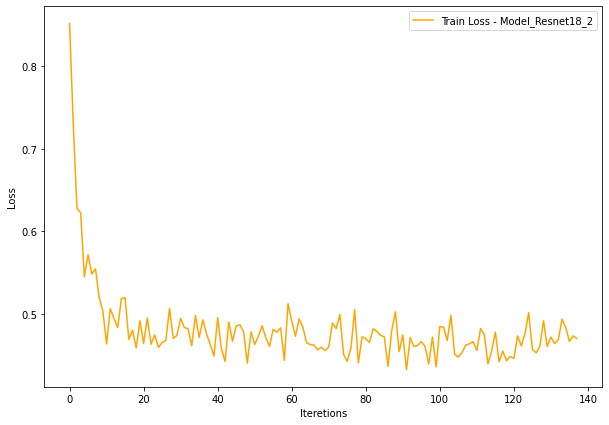

In [ ]:
Test_acc, confusion_matrix = Test_model(model2_resnet18)
print(Test_acc)
print(confusion_matrix)
plots(loss_array_RESNET, "Model_Resnet18_2") # loss plots

Start of Resnet2 Module (Resnet34)

In [ ]:
model_resnet2 = torchvision.models.resnet34(pretrained=False)
model_resnet2 = model_resnet2.to(device)

In [ ]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adamax(model_resnet2.fc.parameters(), lr = learning_rate_RESNET2) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

In [ ]:
loss_array_RESNET2, total_time = train_model(NUM_EPOCHS_RESNET,loader_train_resnet2,optimizer2,criterion2,model_resnet2,"Model_Resnet2",loss_acc=50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 1734/1734 [42:56<00:00,  1.49s/it]

Total time for training:  42.94865135749181


Test started:


Progress: 100%|██████████| 3470/3470 [10:25<00:00,  5.55it/s]


75.26889469417169
tensor([[30261.,  9487.],
        [ 4240., 11517.]])


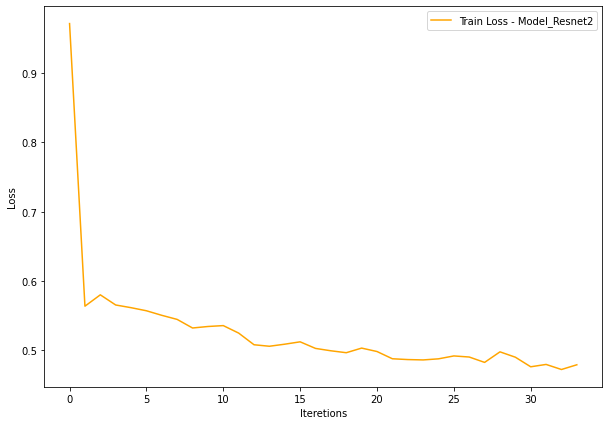

In [ ]:
Test_acc, confusion_matrix = Test_model(model_resnet2)
print(Test_acc)
print(confusion_matrix)
plots(loss_array_RESNET2, "Model_Resnet2") # loss plots

End of Resnet2 Module

Resnet34_2 Module

In [ ]:
model_Resnet34_2 = torchvision.models.resnet34(pretrained=False)
model_Resnet34_2 = model_Resnet34_2.to(device)

In [ ]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adamax(model_Resnet34_2.fc.parameters(), lr = 0.0005) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

In [ ]:
loss_array_RESNET2, total_time = train_model(NUM_EPOCHS_RESNET,loader_train_resnet2,optimizer2,criterion2,model_Resnet34_2,"Model_Resnet34_2",loss_acc=50)
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 1734/1734 [43:45<00:00,  1.51s/it]

Total time for training:  43.76631495952606


Test started:


Progress: 100%|██████████| 3470/3470 [10:30<00:00,  5.50it/s]


78.55868840644987
tensor([[37810.,  1938.],
        [ 9963.,  5794.]])


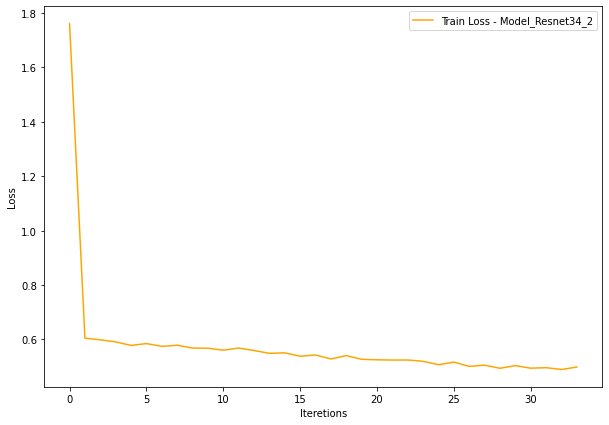

In [ ]:
Test_acc, confusion_matrix = Test_model(model_Resnet34_2)
print(Test_acc)
print(confusion_matrix)
plots(loss_array_RESNET2, "Model_Resnet34_2") # loss plots

Start model DensNet

In [30]:
class DensNet(nn.Module):
    def __init__(self, num_classes=1000, num_channels=3):
        super().__init__()
        preloaded = torchvision.models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [ ]:
model_DensNet = DensNet(num_classes=NUM_CLASSES)
model_DensNet.to(device);

In [32]:
optimizer_DensNet = torch.optim.Adam(model_DensNet.parameters(), learning_rate_DensNet)
criterion_DensNet = nn.CrossEntropyLoss()

In [33]:
loss_array_DensNet, total_time = train_model(NUM_EPOCHS_DENSNET,loader_train_resnet_densnet, optimizer_DensNet,criterion_DensNet,model_DensNet,"Model_DensNet")
print("Total time for training: ", total_time)

Train started:


Progress: 100%|██████████| 3469/3469 [1:24:02<00:00,  1.45s/it]

Total time for training:  84.03599063158035


Test started:


Progress: 100%|██████████| 3470/3470 [13:38<00:00,  4.24it/s]


confusion_matrix:  tensor([[36579.,  3169.],
        [ 4208., 11549.]])
All_Epochs [1],Test_accuracy:86.70930546797585


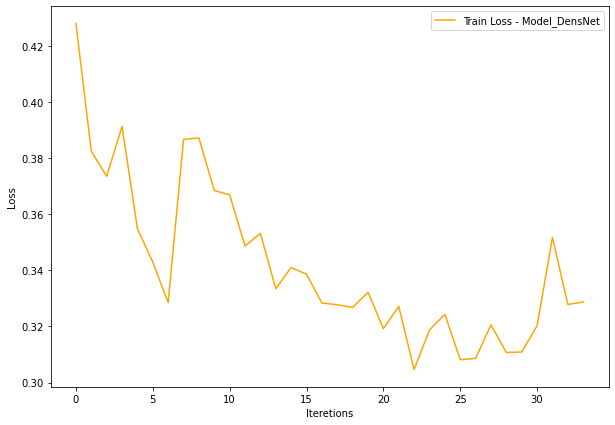

In [34]:
Test_acc, confusion_matrix = Test_model(model_DensNet)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_DENSNET,Test_acc))
plots(loss_array_DensNet, "Model_DensNet") # loss plots

Majority_vote

In [44]:
# Test the model by majority vote
def Test_model_majority_vote(model_1, model_2, model_3):
    model_1.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    model_2.eval()
    model_3.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        tk0 = tqdm(loader_test, total=int(len(loader_test)), desc= "Progress: ")
        for filename, target in tk0:
            filename = filename.to(device)
            target = target.to(device)
            outputs_1 = model_1(filename)
            outputs_2 = model_2(filename)
            outputs_3 = model_3(filename) 
            temp, predicted_1 = torch.max(outputs_1.data, 1)
            temp, predicted_2 = torch.max(outputs_2.data, 1) 
            temp, predicted_3 = torch.max(outputs_3.data, 1)
            predicted = torch.round((predicted_1 + predicted_2 + predicted_3) / 3)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    return Test_acc, confusion_matrix   


In [36]:
Test_acc, confusion_matrix = Test_model_majority_vote(model_Cnn, model_Cnn2, model_DensNet)

Progress: 100%|██████████| 3470/3470 [07:57<00:00,  7.27it/s]


In [37]:
print(Test_acc)
print(confusion_matrix)

87.49482028646068
tensor([[36712.,  3036.],
        [ 3905., 11852.]])


In [38]:
Test_acc, confusion_matrix = Test_model_majority_vote(model_Cnn, model_Cnn2, model_Cnn3)

Progress: 100%|██████████| 3470/3470 [05:09<00:00, 11.22it/s]


In [39]:
print(Test_acc)
print(confusion_matrix)

87.58850554004144
tensor([[36907.,  2841.],
        [ 4048., 11709.]])
